Libraries imported successfully.
Loading and preprocessing data... This may take a minute.
Data loaded. Shape of X: (800, 4096), Shape of y: (800,)

--- Training and Evaluating Classification Models ---
Training KNN (k=5)...
Results for KNN (k=5):
  Accuracy: 0.8875, Precision: 0.8523, Recall: 0.9375, F1-Score: 0.8929


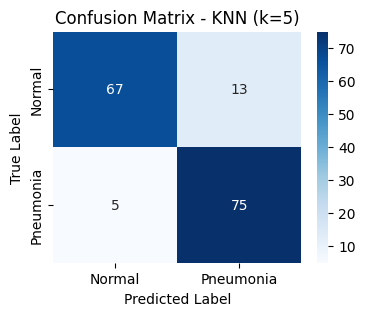

Training Naive Bayes...
Results for Naive Bayes:
  Accuracy: 0.8688, Precision: 0.8554, Recall: 0.8875, F1-Score: 0.8712


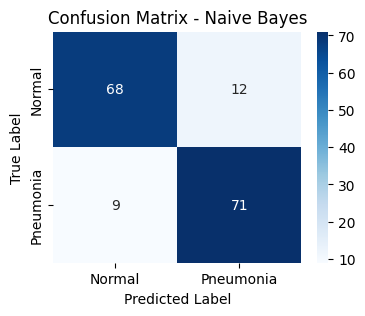

Training Logistic Regression (Choice)...
Results for Logistic Regression (Choice):
  Accuracy: 0.9625, Precision: 0.9625, Recall: 0.9625, F1-Score: 0.9625


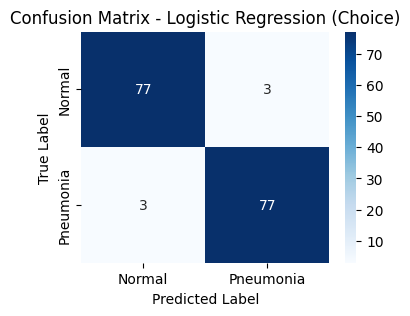


--- Comparison of Classification Algorithms ---
                              Accuracy  Precision  Recall  F1-Score
KNN (k=5)                      0.88750   0.852273  0.9375  0.892857
Naive Bayes                    0.86875   0.855422  0.8875  0.871166
Logistic Regression (Choice)   0.96250   0.962500  0.9625  0.962500

--- Applying K-Means Clustering ---
K-Means clustering complete.
Adjusted Rand Index (comparing clusters to true labels): 0.0023
This score measures the similarity between the true labels and the ones found by clustering. 1.0 is a perfect match.

--- Project Script Finished ---


In [1]:
# --- 1. IMPORT NECESSARY LIBRARIES ---
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

# --- 2. FUNCTION TO LOAD AND PREPROCESS DATA ---
# We'll limit the number of images to make this run fast.
MAX_IMAGES_PER_CLASS = 400 

def load_images(folder_path):
    images = []
    labels = []
    # The subfolders are 'NORMAL' and 'PNEUMONIA'
    for label_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(folder_path, label_name)
        count = 0
        for filename in os.listdir(class_path):
            if count >= MAX_IMAGES_PER_CLASS:
                break
            img_path = os.path.join(class_path, filename)
            try:
                # Read, resize to 64x64, and flatten the image
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img, (64, 64))
                images.append(img_resized.flatten()) # Flatten the 2D image to a 1D array
                labels.append(0 if label_name == 'NORMAL' else 1) # 0 for Normal, 1 for Pneumonia
                count += 1
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# --- 3. LOAD THE DATA ---
# IMPORTANT: Adjust this path to where your 'train' folder is located
train_data_path = '../data/chest_xray/train' # Assumes notebook is in 'notebooks/' folder

print("Loading and preprocessing data... This may take a minute.")
X, y = load_images(train_data_path)
print(f"Data loaded. Shape of X: {X.shape}, Shape of y: {y.shape}")

# --- 4. SPLIT DATA AND TRAIN CLASSIFICATION MODELS ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models to train
models = {
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression (Choice)": LogisticRegression(max_iter=1000)
}

results = {}

print("\n--- Training and Evaluating Classification Models ---")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = [accuracy, precision, recall, f1]
    
    print(f"Results for {name}:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    
    # Plotting confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- 5. DISPLAY COMPARISON OF CLASSIFIERS ---
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
print("\n--- Comparison of Classification Algorithms ---")
print(results_df)

# --- 6. APPLY K-MEANS CLUSTERING ---
print("\n--- Applying K-Means Clustering ---")
# K-Means is unsupervised, so we use only X_train
# We set n_clusters=2 to see if it can find the 'Normal' and 'Pneumonia' groups on its own
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_train)
print("K-Means clustering complete.")
# Note: Evaluating clustering is complex. For this project, simply applying the algorithm is sufficient.
# A common way to check is to see how well the clusters match the actual labels.
from sklearn.metrics import adjusted_rand_score
cluster_labels = kmeans.predict(X_train)
ari = adjusted_rand_score(y_train, cluster_labels)
print(f"Adjusted Rand Index (comparing clusters to true labels): {ari:.4f}")
print("This score measures the similarity between the true labels and the ones found by clustering. 1.0 is a perfect match.")

print("\n--- Project Script Finished ---")